In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/Project'

Mounted at /content/drive


Este notebook levanta la carpeta data que se encuentra en el mismo directorio que el propio notebook y a partir de ella genera una csv y procesa los archivos de audio encontrados para generar espectrogramas de mell

In [1]:
import os
import torch
import torchaudio
import pandas as pd

In [11]:
#creo una bariable root la cual se puede cambiar si se quiere trabajar con otro directorio,
# pero a priori se deja en '.' para trabajar desde el directorio local del proyecto

target_sr = 22000
root = '.'
os.listdir(root + '/data')


['hombre', 'instrumental', 'mujer']

In [26]:
#En esta celda se recorre todo el arbol de carpetas para obtener todos los meta datos de las canciones y los path a sus correspondientes archivos de audio

res = []
for genero in os.listdir(root + '/data'):
  if genero.endswith('.csv'):
    continue
  for artista in os.listdir(root + '/data/' + genero):
    for album in os.listdir(root + '/data/' + genero + '/' + artista):
      if genero == 'instrumental':
        if album.endswith((".mp3", ".wav", ".flac")):

          songName = os.path.splitext(album)[0]
          localPath = '/data/' + genero + '/' + artista
          res.append([genero, artista, genero ,songName, localPath, album])
      else:
        for song in os.listdir(root + '/data/' + genero + '/' + artista + '/' + album):
          if song.endswith((".mp3", ".wav", ".flac")):

            songName = os.path.splitext(song)[0]
            localPath = '/data/' + genero + '/' + artista + '/' + album
            res.append([genero, artista, album, songName, localPath, song])

#creo un archivo csv con los metadatos por si se quiere revisar y debugear
metaData = pd.DataFrame(res, columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak'])
metaData.to_csv("csv/MetaData.csv", index = False)

In [31]:
def _stereo_to_mono(signal , keepdim = False):
  """
  Colapsa todos los canales de la señal en no solo.
  """
  if(signal.shape[0] > 1):
    signal = torch.mean(signal, dim=0, keepdim= keepdim ) #, keepdim= True
  return signal

def _spliter(tensor, sr, time):
  """
  Recibe un tensor y un tiempo en segundos.
  Retorna el tensro original segmentado en muestras del tiempo recibido.
  En caso de el rcorte no sea exacto, se le agrega zero padding al final.
  """
  num_samples = int(sr * time)
  padding = torch.zeros(num_samples - len(tensor)%num_samples)
  splited = torch.split(torch.cat((tensor, padding)), num_samples)
  return splited

def _time_fixer(signal, sr, time):
  """
  Recibe una señal y un tiempo en segundos.
  En caso de que la señal dure menos de tiempo indicado se le agrega zero padding
  al final.
  En caso de que la señal dure mas de tiempo indicado se le recortan las ultimas muestras
  """
  if(signal.shape[0] < time*sr):
    padding = torch.zeros( time*sr - signal.shape[0])
    fixed_signal = torch.cat((signal, padding))
  elif(signal.shape[0] > time*sr):
    fixed_signal = signal[:time*sr]
  else:
    fixed_signal = signal
  return fixed_signal


def _preacondicionar_audio(signal, native_sr, target_sr, dur_sample = 10, dur_fix = 5*60):
  """
  Se genera un resample de la señal de audio, luego cambia el canal de audio a mono.
  Despues se generan muestras de la señal de audio de 10 segundos y funalmente se fixea la señal de audio a un tiempo de 5 minutos.
  """
  if( native_sr != target_sr):  #resample
    resampler = torchaudio.transforms.Resample(native_sr, target_sr)
    signal = resampler(signal)
  signal = _stereo_to_mono(signal)
  muestras = _spliter(signal, target_sr, dur_sample)
  fixed_signal = _time_fixer(signal, target_sr, dur_fix)
  return fixed_signal, muestras, target_sr

#signal, sr = torchaudio.load(fPath)
#signal, sr = _preacondicionar_audio(signal, sr, target_sr)
MelCalculator = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr,
                                                       n_fft = 1024,
                                                       hop_length = 512,
                                                       n_mels = 64)

In [32]:
# M/F/I     indica si el artista es Male, Female, Instrumental
# artist    indica el nombre del artista o banda
# album
# song      indica el nombre de la cncion
# localPath indica la ruta de la carpeta donde esta contenida la cancion
# fileTrak  indica el nombre del archivo que contiene la pista de audio
# fileMel  indica el nombre del espectrograma de mel
# sample/full indica si el espectrograma es calculado respecto a toda la cancion o respecto a un sample de 10 seg
df = pd.DataFrame(columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak', 'fileMel', 'sample/full'])


In [34]:
data = []
errors = []
count = 9
for entry in res:
  trakPath = root + entry[4] + '/' + entry[5]
  try:
    #print('Loading:', trakPath)
    signal, sr = torchaudio.load(trakPath)
  except:
    errors.append(trakPath)
    #print('Error:', trakPath)
    continue
  signal, muestras, sr = _preacondicionar_audio(signal, sr, target_sr)
  melIndex = 0
  mel = MelCalculator(signal)
  fileMel = entry[3] + ' ' + str(melIndex) +'.pt'
  MelSave = root + entry[4] + '/' + fileMel
  torch.save(mel, MelSave)
  data.append([entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], fileMel, 'full'])

  for sample in muestras:
    melIndex += 1
    mel = MelCalculator(sample)
    fileMel = entry[3] + ' ' + str(melIndex) +'.pt'
    MelSave = root + entry[4] + '/' + fileMel
    torch.save(mel, MelSave)
    data.append([entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], fileMel, 'sample'])
  
  count = count +1
  if( not (count % 10)):
    print(count)

print(data)
  #npsave(fileMel, mel)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
[['hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 0.pt', 'full'], ['hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 1.pt', 'sample'], ['hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/hombre/Imagine Dragons/Evolve', '01 Next

In [35]:
df = pd.DataFrame(data, columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak', 'fileMel', 'sample/full'])
error_df = pd.DataFrame(errors, columns=['error_path'])
print(df)


        M/F/I           artist  \
0      hombre  Imagine Dragons   
1      hombre  Imagine Dragons   
2      hombre  Imagine Dragons   
3      hombre  Imagine Dragons   
4      hombre  Imagine Dragons   
...       ...              ...   
33259   mujer     Taylor Swift   
33260   mujer     Taylor Swift   
33261   mujer     Taylor Swift   
33262   mujer     Taylor Swift   
33263   mujer     Taylor Swift   

                                                   album                song  \
0                                                 Evolve       01 Next To Me   
1                                                 Evolve       01 Next To Me   
2                                                 Evolve       01 Next To Me   
3                                                 Evolve       01 Next To Me   
4                                                 Evolve       01 Next To Me   
...                                                  ...                 ...   
33259  THE TORTURED POETS DEPAR

In [36]:
for error in errors:
    print(error)

./data/hombre/Imagine Dragons/Night Visions/06 Amsterdam.mp3
./data/instrumental/Panic! at the disco/Panic_ At The Disco - Do It To Death (Official Instrumental)(MP3_320K).mp3


In [38]:
df.to_csv('./csv/data.csv', index=False)
error_df.to_csv('./csv/errors.csv', index=False)

# Reconstructor

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [102]:
os.listdir(root + '/data')

['Hombre', 'Mujer', 'Instrumental', 'data.csv']

In [151]:
i_sample = 5
mel_recuperado = torch.load(root + df.at[i_sample, 'localPath'] + '/' + df.at[i_sample, 'fileMel'])
print(mel_recuperado.shape)

torch.Size([64, 430])


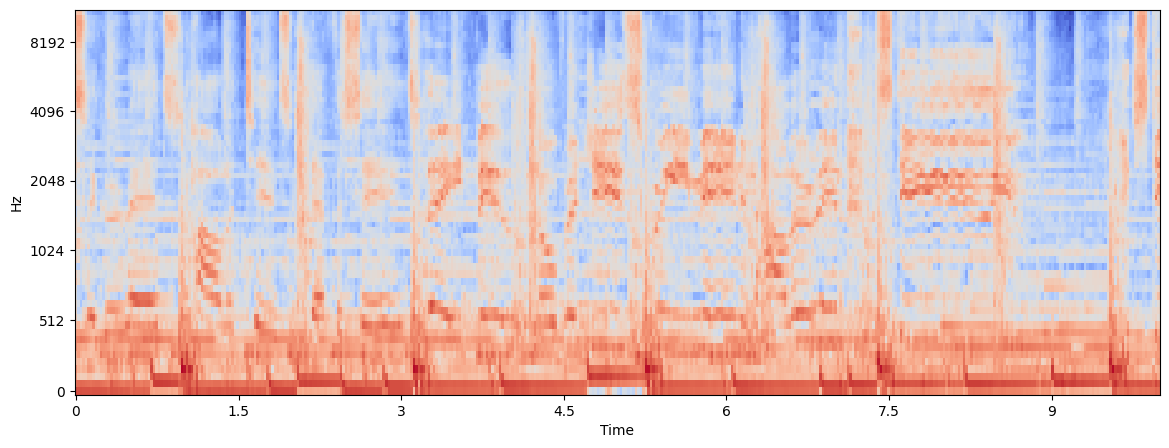

In [152]:
plt.figure(figsize= (14, 5))
librosa.display.specshow(librosa.power_to_db(mel_recuperado), sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')